### Connect to Drive

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/Progetto AN2DL/5_ImageAugmentation

### Import libraries

In [ ]:
# Hide warnings
import os

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np

import logging

In [ ]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
from tensorflow.keras.preprocessing.image import ImageDataGenerator
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
print(tf.__version__)

In [ ]:
# Import other libraries
import cv2
from tensorflow.keras.applications.mobilenet import preprocess_input
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
import pickle

### Load and process the dataset

In [ ]:
# Load data
data = np.load('../clean_data.npz', allow_pickle=True)

# Save images in a new list (image pixel values are float in [0, 1])
images = data['data']

# Save labels in a new list
labels = data['labels']

# Print data shape
print(images.shape, labels.shape)

In [ ]:
# Convert labels from string to integer
num_labels = []
for label in labels:
  if label == "healthy":
    num_labels.append(0)
  else:
    num_labels.append(1)

# Convert labels in the one-hot encoding format
num_labels = np.array(num_labels)
labels = tfk.utils.to_categorical(num_labels, 2)

# Split data into train and val sets
X_train, X_val, y_train, y_val = train_test_split(
    images,
    labels,
    test_size=0.1,
    stratify=labels
)

# Print shapes of the datasets
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")

### ConvNeXtLarge

In [ ]:
# Import Feature Extractor with specified settings
feature_extractor = tfk.applications.ConvNeXtLarge(
    input_shape=(96, 96, 3),
    include_top=False,
    weights="imagenet",
    pooling='avg',
    include_preprocessing=True,
)

785596384/785596384 [==============================] - 10s 0us/step


### Model

In [ ]:
# Define network parameters/callbacks
dropout_rate = 1/10
learning_rate = 1e-3

lr_scheduler = tfk.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',
    patience=5,
    factor=0.999,
    mode='max',
    min_lr=1e-5
)

early_stopping = tfk.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=20,
    restore_best_weights=True
)

In [ ]:
def build_model(feature_extractor, dropout_rate, learning_rate=0.001):
  # Use the supernet as feature extractor, i.e. freeze all its weigths
  feature_extractor.trainable = False

  # Create an input layer with shape (96, 96, 3)
  inputs = tfk.Input(shape=(96, 96, 3), name='Input')

  # Connect FeatureExtractor to the input
  x = feature_extractor(inputs)

  # Hidden layers
  x = tfkl.Dense(units=256, name='HiddenDense1')(x)
  x = tfkl.Activation('relu', name='HiddenActivation1')(x)
  dropout = tfkl.Dropout(dropout_rate)(x)
  x = tfkl.Dense(units=256, name='HiddenDense2')(dropout)
  x = tfkl.Activation('relu', name='HiddenActivation2')(x)
  dropout = tfkl.Dropout(dropout_rate)(x)

  # Add a Dense layer with 2 unit and softmax activation as the classifier
  outputs = tfkl.Dense(2, activation='softmax')(dropout)

  # Create a Model connecting input and output
  model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

  # Compile the model with Categorical Cross-Entropy loss and Adam optimizer
  model.compile(loss=tfk.losses.CategoricalCrossentropy(),
                optimizer=tfk.optimizers.Adam(learning_rate),
                metrics=['accuracy'])

  # Return the model
  return model

In [ ]:
model = build_model(feature_extractor, dropout_rate, learning_rate)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 96, 96, 3)]       0         
                                                                 
 convnext_large (Functional  (None, 1536)              196230336 
 )                                                               
                                                                 
 HiddenDense1 (Dense)        (None, 256)               393472    
                                                                 
 HiddenActivation1 (Activat  (None, 256)               0         
 ion)                                                            
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 HiddenDense2 (Dense)        (None, 256)               65792 

In [ ]:
# Train the model
history = model.fit(
    x = X_train*255,
    y = y_train,
    batch_size = 16,
    epochs = 200,
    validation_data = (X_val*255, y_val),
    callbacks = [early_stopping, lr_scheduler]
).history

Epoch 1/200
282/282 [==============================] - 94s 203ms/step - loss: 0.4686 - accuracy: 0.7901 - val_loss: 0.4191 - val_accuracy: 0.8004 - lr: 0.0010
Epoch 2/200
282/282 [==============================] - 40s 142ms/step - loss: 0.3386 - accuracy: 0.8559 - val_loss: 0.3384 - val_accuracy: 0.8643 - lr: 0.0010
Epoch 3/200
282/282 [==============================] - 41s 145ms/step - loss: 0.2883 - accuracy: 0.8783 - val_loss: 0.3352 - val_accuracy: 0.8683 - lr: 0.0010
Epoch 4/200
282/282 [==============================] - 40s 142ms/step - loss: 0.2581 - accuracy: 0.8987 - val_loss: 0.3136 - val_accuracy: 0.8683 - lr: 0.0010
Epoch 5/200
282/282 [==============================] - 41s 144ms/step - loss: 0.2352 - accuracy: 0.8978 - val_loss: 0.2729 - val_accuracy: 0.8982 - lr: 0.0010
Epoch 6/200
282/282 [==============================] - 42s 148ms/step - loss: 0.2142 - accuracy: 0.9107 - val_loss: 0.3073 - val_accuracy: 0.8862 - lr: 0.0010
Epoch 7/200
282/282 [=========================

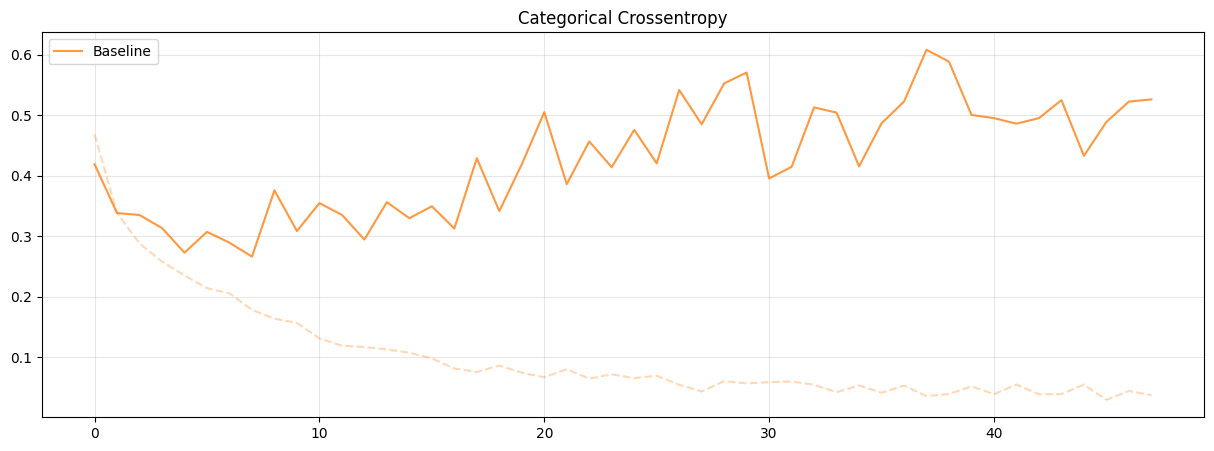

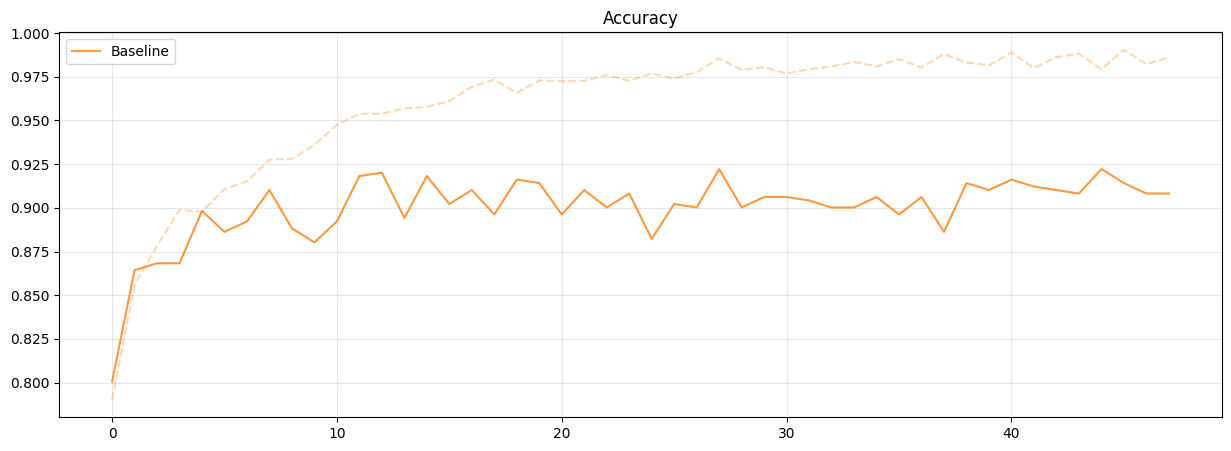

In [ ]:
# Plot the training histories
plt.figure(figsize=(15,5))
plt.plot(history['loss'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_loss'], label='Baseline', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_accuracy'], label='Baseline', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [ ]:
# Save the model
model.save('Augmentation')
with open('Augmentation/history.pkl', 'wb') as f:
  pickle.dump(history, f)

### FLIP

In [ ]:
model = build_model(feature_extractor, dropout_rate, learning_rate)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 96, 96, 3)]       0         
                                                                 
 convnext_large (Functional  (None, 1536)              196230336 
 )                                                               
                                                                 
 HiddenDense1 (Dense)        (None, 256)               393472    
                                                                 
 HiddenActivation1 (Activat  (None, 256)               0         
 ion)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 HiddenDense2 (Dense)        (None, 256)               65792 

In [ ]:
train_datagen = ImageDataGenerator(
        horizontal_flip=True,
        vertical_flip = True,
        fill_mode='reflect')

In [ ]:
history_flip = model.fit_generator(train_datagen.flow(X_train*255, y_train,
                              batch_size=16),
                              epochs=200,
                              steps_per_epoch=len(X_train)/16,
                              validation_data = (X_val*255, y_val),
                              callbacks = [early_stopping, lr_scheduler]
                              ).history

Epoch 1/200
281/281 [==============================] - 85s 207ms/step - loss: 0.4917 - accuracy: 0.7704 - val_loss: 0.3721 - val_accuracy: 0.8303 - lr: 0.0010
Epoch 2/200
281/281 [==============================] - 43s 153ms/step - loss: 0.3445 - accuracy: 0.8501 - val_loss: 0.3332 - val_accuracy: 0.8543 - lr: 0.0010
Epoch 3/200
281/281 [==============================] - 43s 152ms/step - loss: 0.3051 - accuracy: 0.8690 - val_loss: 0.3083 - val_accuracy: 0.8723 - lr: 0.0010
Epoch 4/200
281/281 [==============================] - 41s 145ms/step - loss: 0.2802 - accuracy: 0.8819 - val_loss: 0.3123 - val_accuracy: 0.8623 - lr: 0.0010
Epoch 5/200
281/281 [==============================] - 43s 151ms/step - loss: 0.2516 - accuracy: 0.8927 - val_loss: 0.2613 - val_accuracy: 0.8982 - lr: 0.0010
Epoch 6/200
281/281 [==============================] - 40s 142ms/step - loss: 0.2349 - accuracy: 0.9067 - val_loss: 0.2771 - val_accuracy: 0.8922 - lr: 0.0010
Epoch 7/200
281/281 [=========================

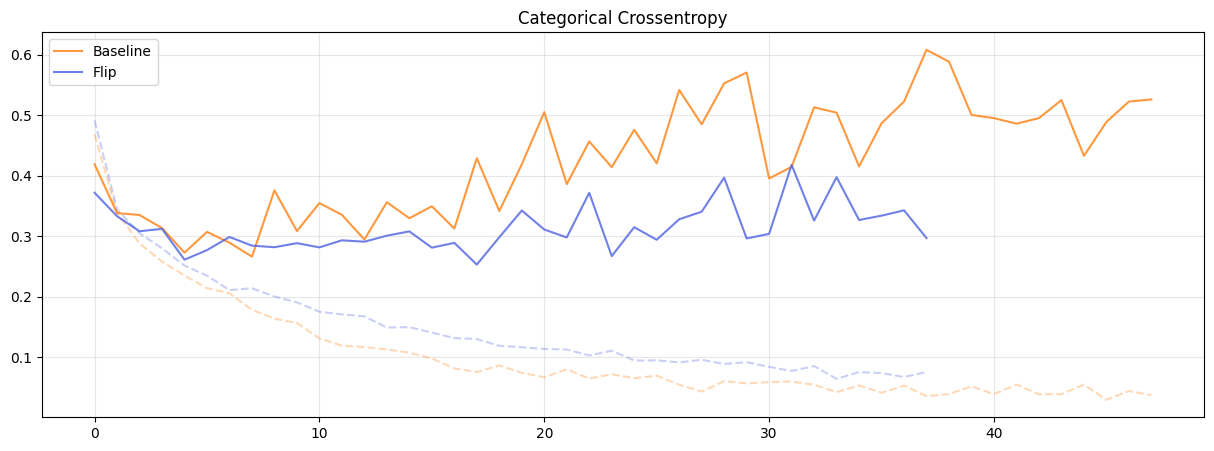

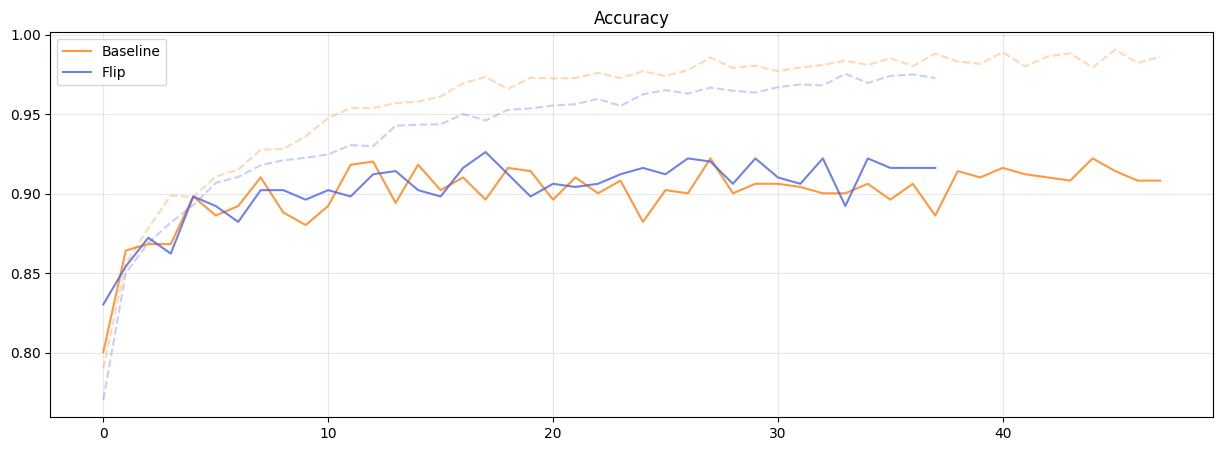

In [ ]:
# Plot the training histories
plt.figure(figsize=(15,5))
plt.plot(history['loss'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_loss'], label='Baseline', alpha=.8, color='#ff7f0e')
plt.plot(history_flip['loss'], alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(history_flip['val_loss'], label='Flip', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_accuracy'], label='Baseline', alpha=.8, color='#ff7f0e')
plt.plot(history_flip['accuracy'], alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(history_flip['val_accuracy'], label='Flip', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [ ]:
# Save the model
model.save('Augmentation_Flip')
with open('Augmentation_Flip/history.pkl', 'wb') as f:
  pickle.dump(history_flip, f)

### ROTATION

In [ ]:
model = build_model(feature_extractor, dropout_rate, learning_rate)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 96, 96, 3)]       0         
                                                                 
 convnext_large (Functional  (None, 1536)              196230336 
 )                                                               
                                                                 
 HiddenDense1 (Dense)        (None, 256)               393472    
                                                                 
 HiddenActivation1 (Activat  (None, 256)               0         
 ion)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 HiddenDense2 (Dense)        (None, 256)               65792 

In [ ]:
train_datagen = ImageDataGenerator(
        rotation_range=90.,
        fill_mode='reflect')

In [ ]:
history_rotation = model.fit_generator(train_datagen.flow(X_train*255, y_train,
                              batch_size=16),
                              epochs=200,
                              steps_per_epoch=len(X_train)/16,
                              validation_data = (X_val*255, y_val),
                              callbacks = [early_stopping, lr_scheduler]
                              ).history

Epoch 1/200
281/281 [==============================] - 72s 176ms/step - loss: 0.4949 - accuracy: 0.7622 - val_loss: 0.4394 - val_accuracy: 0.8283 - lr: 0.0010
Epoch 2/200
281/281 [==============================] - 45s 160ms/step - loss: 0.3658 - accuracy: 0.8363 - val_loss: 0.3522 - val_accuracy: 0.8483 - lr: 0.0010
Epoch 3/200
281/281 [==============================] - 45s 161ms/step - loss: 0.3371 - accuracy: 0.8534 - val_loss: 0.3159 - val_accuracy: 0.8663 - lr: 0.0010
Epoch 4/200
281/281 [==============================] - 46s 162ms/step - loss: 0.3057 - accuracy: 0.8688 - val_loss: 0.2916 - val_accuracy: 0.8842 - lr: 0.0010
Epoch 5/200
281/281 [==============================] - 43s 152ms/step - loss: 0.2823 - accuracy: 0.8803 - val_loss: 0.3038 - val_accuracy: 0.8762 - lr: 0.0010
Epoch 6/200
281/281 [==============================] - 42s 150ms/step - loss: 0.2761 - accuracy: 0.8805 - val_loss: 0.2917 - val_accuracy: 0.8782 - lr: 0.0010
Epoch 7/200
281/281 [=========================

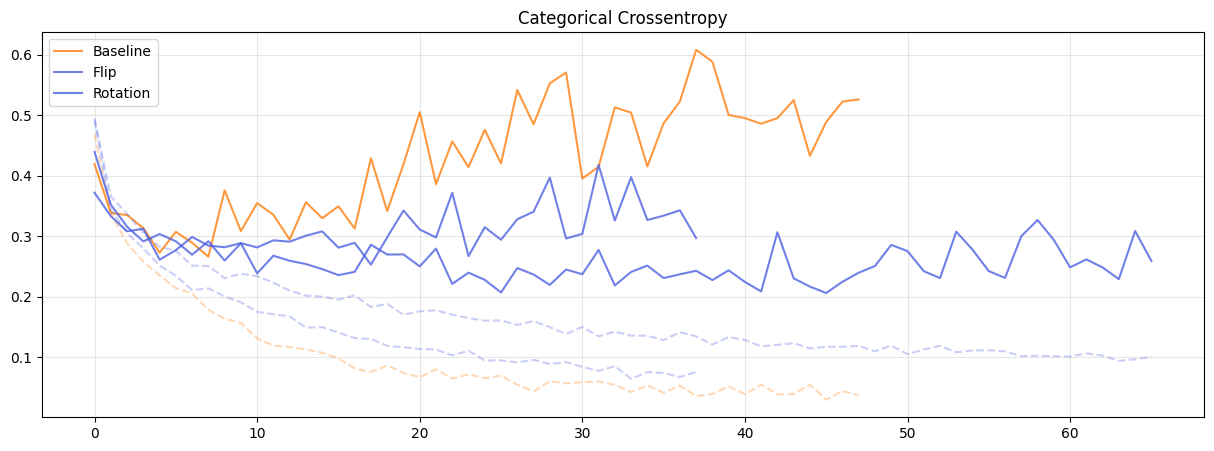

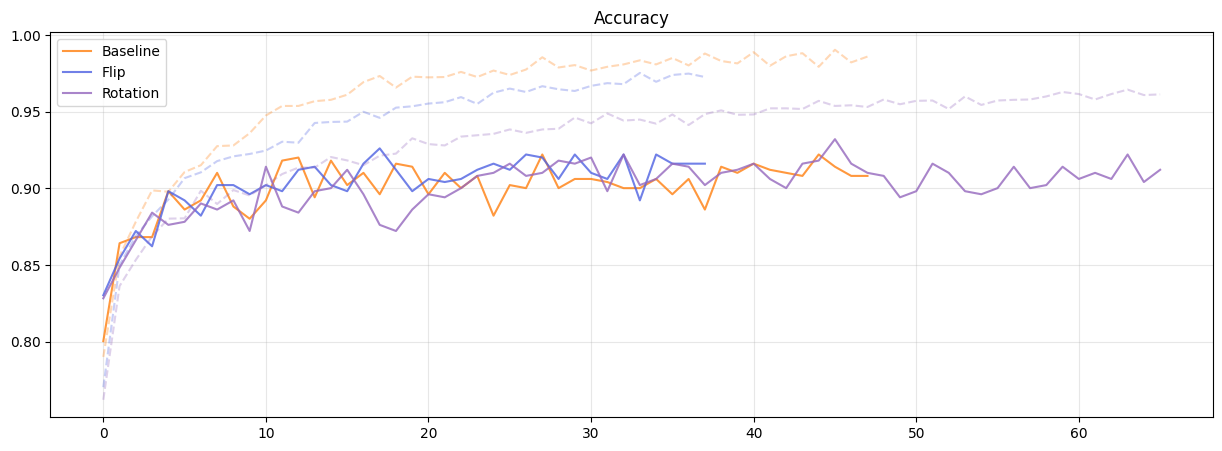

In [ ]:
# Plot the training histories
plt.figure(figsize=(15,5))
plt.plot(history['loss'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_loss'], label='Baseline', alpha=.8, color='#ff7f0e')
plt.plot(history_rotation['loss'], alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(history_rotation['val_loss'], label='Rotation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_accuracy'], label='Baseline', alpha=.8, color='#ff7f0e')
plt.plot(history_rotation['accuracy'], alpha=.3, color='#9467BD', linestyle='--')
plt.plot(history_rotation['val_accuracy'], label='Rotation', alpha=.8, color='#9467BD')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [ ]:
# Save the model
model.save('Augmentation_Rotation')
with open('Augmentation_Rotation/history.pkl', 'wb') as f:
  pickle.dump(history_rotation, f)

### SHIFT

In [ ]:
model = build_model(feature_extractor, dropout_rate, learning_rate)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 96, 96, 3)]       0         
                                                                 
 convnext_large (Functional  (None, 1536)              196230336 
 )                                                               
                                                                 
 HiddenDense1 (Dense)        (None, 256)               393472    
                                                                 
 HiddenActivation1 (Activat  (None, 256)               0         
 ion)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 256)               0         
                                                                 
 HiddenDense2 (Dense)        (None, 256)               65792 

In [ ]:
train_datagen = ImageDataGenerator(
        width_shift_range = 0.1,
        height_shift_range = 0.1,
        fill_mode='reflect')


In [ ]:
history_shift = model.fit_generator(train_datagen.flow(X_train*255, y_train,
                              batch_size=16),
                              epochs=200,
                              steps_per_epoch=len(X_train)/16,
                              validation_data = (X_val*255, y_val),
                              callbacks = [early_stopping, lr_scheduler]
                              ).history

Epoch 1/200
281/281 [==============================] - 74s 181ms/step - loss: 0.4926 - accuracy: 0.7761 - val_loss: 0.3590 - val_accuracy: 0.8423 - lr: 0.0010
Epoch 2/200
281/281 [==============================] - 44s 156ms/step - loss: 0.3721 - accuracy: 0.8337 - val_loss: 0.3274 - val_accuracy: 0.8563 - lr: 0.0010
Epoch 3/200
281/281 [==============================] - 45s 161ms/step - loss: 0.3286 - accuracy: 0.8570 - val_loss: 0.3016 - val_accuracy: 0.8822 - lr: 0.0010
Epoch 4/200
281/281 [==============================] - 46s 164ms/step - loss: 0.3143 - accuracy: 0.8623 - val_loss: 0.3511 - val_accuracy: 0.8563 - lr: 0.0010
Epoch 5/200
281/281 [==============================] - 48s 170ms/step - loss: 0.2809 - accuracy: 0.8814 - val_loss: 0.3069 - val_accuracy: 0.8802 - lr: 0.0010
Epoch 6/200
281/281 [==============================] - 47s 167ms/step - loss: 0.2595 - accuracy: 0.8903 - val_loss: 0.2985 - val_accuracy: 0.8723 - lr: 0.0010
Epoch 7/200
281/281 [=========================

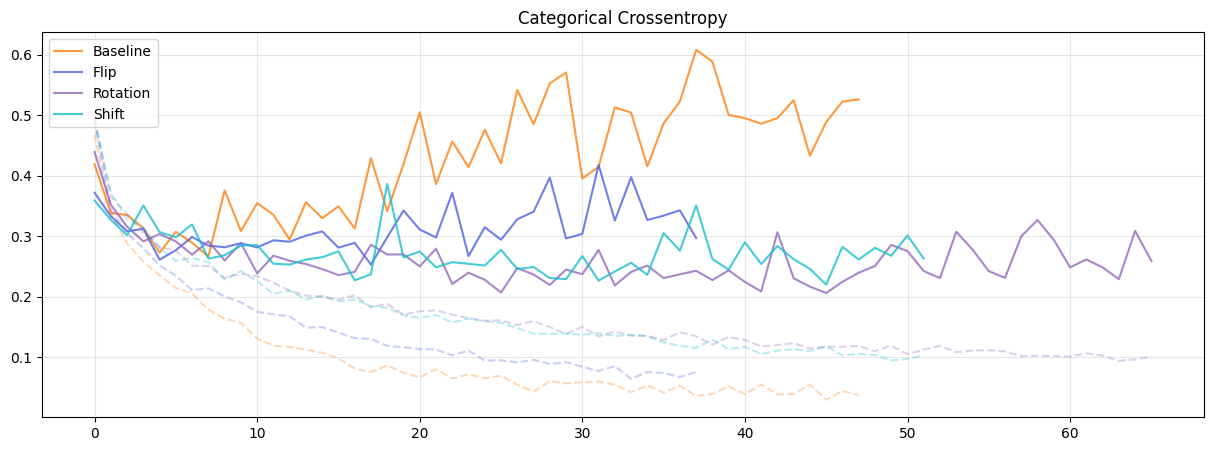

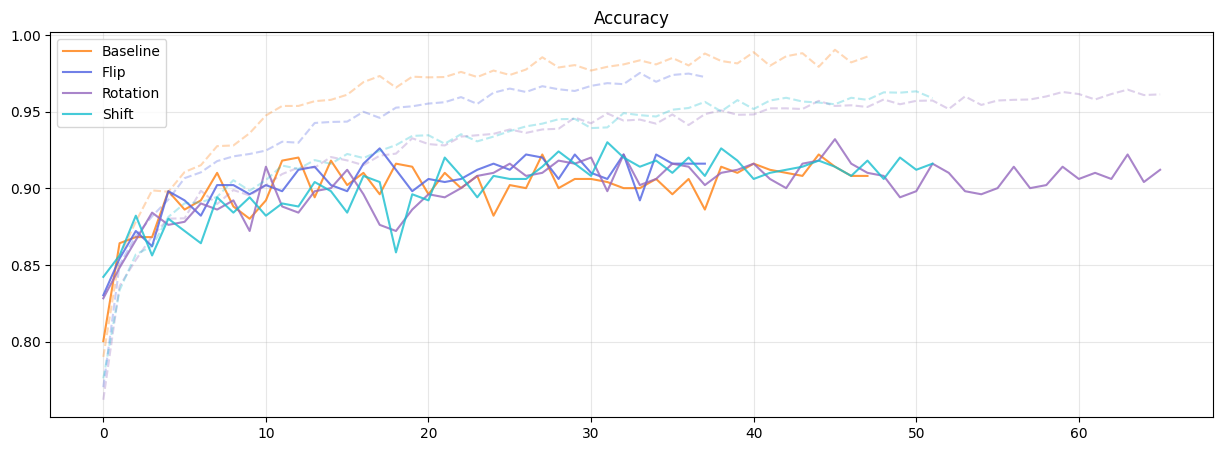

In [ ]:
# Plot the training histories
plt.figure(figsize=(15,5))
plt.plot(history['loss'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_loss'], label='Baseline', alpha=.8, color='#ff7f0e')
plt.plot(history_shift['loss'], alpha=.3, color='#17BECF', linestyle='--')
plt.plot(history_shift['val_loss'], label='Shift', alpha=.8, color='#17BECF')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_accuracy'], label='Baseline', alpha=.8, color='#ff7f0e')
plt.plot(history_shift['accuracy'], alpha=.3, color='#17BECF', linestyle='--')
plt.plot(history_shift['val_accuracy'], label='Shift', alpha=.8, color='#17BECF')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [ ]:
# Save the model
model.save('Augmentation_Shift')
with open('Augmentation_Shift/history.pkl', 'wb') as f:
  pickle.dump(history_shift, f)

### ZOOM

In [ ]:
model = build_model(feature_extractor, dropout_rate, learning_rate)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 96, 96, 3)]       0         
                                                                 
 convnext_large (Functional  (None, 1536)              196230336 
 )                                                               
                                                                 
 HiddenDense1 (Dense)        (None, 256)               393472    
                                                                 
 HiddenActivation1 (Activat  (None, 256)               0         
 ion)                                                            
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 HiddenDense2 (Dense)        (None, 256)               65792 

In [ ]:
train_datagen = ImageDataGenerator(
        zoom_range=0.1,
        fill_mode='reflect')


In [ ]:
history_zoom = model.fit_generator(train_datagen.flow(X_train*255, y_train,
                              batch_size=16),
                              epochs=200,
                              steps_per_epoch=len(X_train)/16,
                              validation_data = (X_val*255, y_val),
                              callbacks = [early_stopping, lr_scheduler]
                              ).history

Epoch 1/200
281/281 [==============================] - 100s 213ms/step - loss: 0.4885 - accuracy: 0.7699 - val_loss: 0.3364 - val_accuracy: 0.8323 - lr: 0.0010
Epoch 2/200
281/281 [==============================] - 44s 157ms/step - loss: 0.3480 - accuracy: 0.8450 - val_loss: 0.3024 - val_accuracy: 0.8583 - lr: 0.0010
Epoch 3/200
281/281 [==============================] - 41s 144ms/step - loss: 0.3070 - accuracy: 0.8694 - val_loss: 0.4129 - val_accuracy: 0.8144 - lr: 0.0010
Epoch 4/200
281/281 [==============================] - 41s 144ms/step - loss: 0.2923 - accuracy: 0.8690 - val_loss: 0.2685 - val_accuracy: 0.8822 - lr: 0.0010
Epoch 5/200
281/281 [==============================] - 42s 149ms/step - loss: 0.2570 - accuracy: 0.8921 - val_loss: 0.2824 - val_accuracy: 0.8703 - lr: 0.0010
Epoch 6/200
281/281 [==============================] - 42s 149ms/step - loss: 0.2450 - accuracy: 0.9005 - val_loss: 0.2711 - val_accuracy: 0.8802 - lr: 0.0010
Epoch 7/200
281/281 [========================

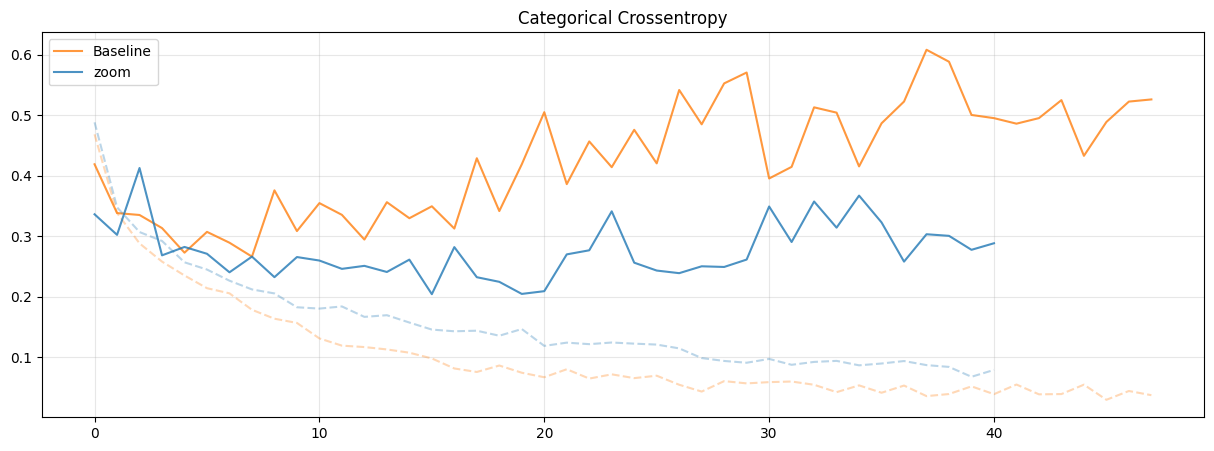

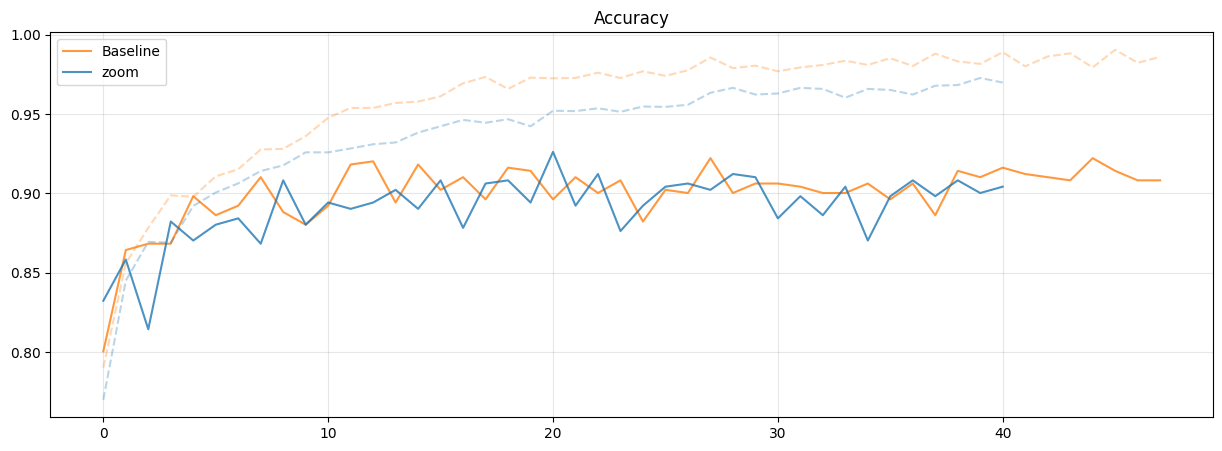

In [ ]:
# Plot the training histories
plt.figure(figsize=(15,5))
plt.plot(history['loss'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_loss'], label='Baseline', alpha=.8, color='#ff7f0e')
plt.plot(history_zoom['loss'], alpha=.3, color='#1f77b4', linestyle='--')
plt.plot(history_zoom['val_loss'], label='zoom', alpha=.8, color='#1f77b4')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_accuracy'], label='Baseline', alpha=.8, color='#ff7f0e')
plt.plot(history_zoom['accuracy'], alpha=.3, color='#1f77b4', linestyle='--')
plt.plot(history_zoom['val_accuracy'], label='zoom', alpha=.8, color='#1f77b4')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [ ]:
# Save the model
model.save('Augmentation_Zoom')
with open('Augmentation_Zoom/history.pkl', 'wb') as f:
  pickle.dump(history_zoom, f)

### SHEAR

In [ ]:
model = build_model(feature_extractor, dropout_rate, learning_rate)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 96, 96, 3)]       0         
                                                                 
 convnext_large (Functional  (None, 1536)              196230336 
 )                                                               
                                                                 
 HiddenDense1 (Dense)        (None, 256)               393472    
                                                                 
 HiddenActivation1 (Activat  (None, 256)               0         
 ion)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 HiddenDense2 (Dense)        (None, 256)               65792 

In [ ]:
train_datagen = ImageDataGenerator(
        shear_range=0.1,
        fill_mode='reflect')


In [ ]:
history_shear = model.fit_generator(train_datagen.flow(X_train*255, y_train,
                              batch_size=16),
                              epochs=200,
                              steps_per_epoch=len(X_train)/16,
                              validation_data = (X_val*255, y_val),
                              callbacks = [early_stopping, lr_scheduler]
                              ).history

Epoch 1/200
281/281 [==============================] - 67s 170ms/step - loss: 0.4648 - accuracy: 0.7888 - val_loss: 0.3622 - val_accuracy: 0.8383 - lr: 0.0010
Epoch 2/200
281/281 [==============================] - 42s 151ms/step - loss: 0.3385 - accuracy: 0.8579 - val_loss: 0.3166 - val_accuracy: 0.8543 - lr: 0.0010
Epoch 3/200
281/281 [==============================] - 43s 152ms/step - loss: 0.2820 - accuracy: 0.8827 - val_loss: 0.2839 - val_accuracy: 0.8842 - lr: 0.0010
Epoch 4/200
281/281 [==============================] - 42s 150ms/step - loss: 0.2507 - accuracy: 0.8923 - val_loss: 0.2935 - val_accuracy: 0.8603 - lr: 0.0010
Epoch 5/200
281/281 [==============================] - 43s 151ms/step - loss: 0.2388 - accuracy: 0.9045 - val_loss: 0.2438 - val_accuracy: 0.8922 - lr: 0.0010
Epoch 6/200
281/281 [==============================] - 43s 152ms/step - loss: 0.2157 - accuracy: 0.9118 - val_loss: 0.2363 - val_accuracy: 0.8942 - lr: 0.0010
Epoch 7/200
281/281 [=========================

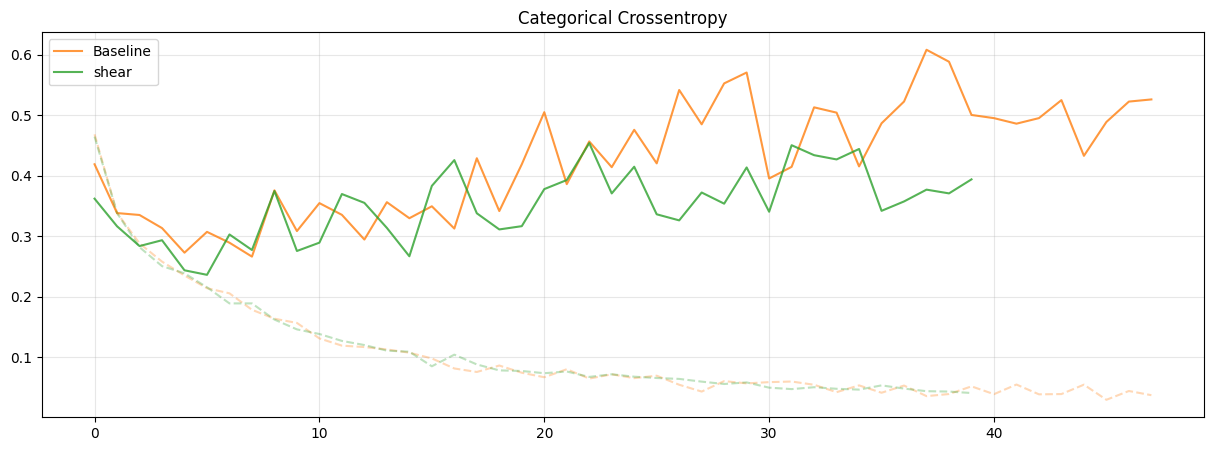

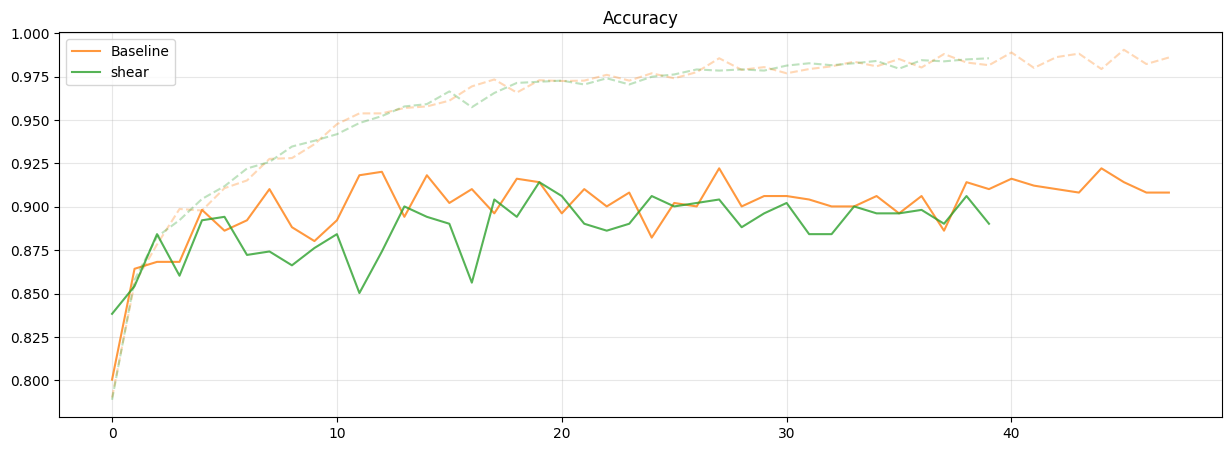

In [ ]:
# Plot the training histories
plt.figure(figsize=(15,5))
plt.plot(history['loss'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_loss'], label='Baseline', alpha=.8, color='#ff7f0e')
plt.plot(history_shear['loss'], alpha=.3, color='#2ca02c', linestyle='--')
plt.plot(history_shear['val_loss'], label='shear', alpha=.8, color='#2ca02c')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_accuracy'], label='Baseline', alpha=.8, color='#ff7f0e')
plt.plot(history_shear['accuracy'], alpha=.3, color='#2ca02c', linestyle='--')
plt.plot(history_shear['val_accuracy'], label='shear', alpha=.8, color='#2ca02c')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [ ]:
# Save the model
model.save('Augmentation_Shear')
with open('Augmentation_Shear/history.pkl', 'wb') as f:
  pickle.dump(history_shear, f)

In [ ]:
for i in range(20):
  print(f"label {i}: {labels[i]}")
out = model.predict(images[0:20]*255, verbose=0)
for i in out:
  print(i)

### BRIGHTNESS

In [ ]:
model = build_model(feature_extractor, dropout_rate, learning_rate)
model.summary()

In [ ]:
train_datagen = ImageDataGenerator(
        brightness_range=(0.8, 1.2),
        fill_mode = 'reflect')


In [ ]:
history_bright = model.fit_generator(train_datagen.flow(X_train*255, y_train,
                              batch_size=16),
                              epochs=200,
                              steps_per_epoch=len(X_train)/16,
                              validation_data = (X_val*255, y_val),
                              callbacks = [early_stopping, lr_scheduler]
                              ).history

In [ ]:
# Plot the training histories
plt.figure(figsize=(15,5))
plt.plot(history['loss'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_loss'], label='Baseline', alpha=.8, color='#ff7f0e')
plt.plot(history_bright['loss'], alpha=.3, color='#d62728', linestyle='--')
plt.plot(history_bright['val_loss'], label='bright', alpha=.8, color='#d62728')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_accuracy'], label='Baseline', alpha=.8, color='#ff7f0e')
plt.plot(history_bright['accuracy'], alpha=.3, color='#d62728', linestyle='--')
plt.plot(history_bright['val_accuracy'], label='bright', alpha=.8, color='#d62728')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [ ]:
# Save the model
model.save('Augmentation_Brightness')
with open('Augmentation_Brightness/history.pkl', 'wb') as f:
  pickle.dump(history_bright, f)